# Evaluation of PAAM static offset angle for correctness 

view this page at https://mybinder.org/v2/gh/eliasbreunig/PAA_analysis/HEAD?urlpath=tree/paa_angles.ipynb

## Imports and Initializations

In [220]:
%matplotlib widget
import numpy as np
from matplotlib import pyplot
import transforms3d as t3d
from transforms3d.utils import normalized_vector as nvector
import pytransform3d as p3d
from pytransform3d.transform_manager import TransformManager

# init the scenegraph
sg = TransformManager()

X = 0
Y = 1
Z = 2

## Definitions of Coordinate Frames

In [221]:
# Definition of:
# the MOSA frame relative to the SC frame (rotation of 30deg aroung Z to match constellation angle plus some arbitrary translation)
sc2mosa1_trafo_trans = p3d.transformations.transform_from(np.identity(3),np.multiply(-1,[0,1,0])) # translation in parent coordinates
sc2mosa1_trafo_rot = p3d.transformations.transform_from(p3d.rotations.passive_matrix_from_angle(Z, 30./180.*np.pi),[0,0,0])

sc2mosa1_trafo = sc2mosa1_trafo_rot @ sc2mosa1_trafo_trans

# the OB frame relative to the MOSA frame (just a translation along X)
mosa2ob_trafo = p3d.transformations.transform_from(np.identity(3),np.multiply(-1,[0.5,0,0]))
# the PAAM frame relative to the MOSA frame (just a translation along X)
ob2paam_trafo_trans = p3d.transformations.transform_from(np.identity(3),np.multiply(-1,[0.0,0.05,-0.12]))
ob2paam_trafo_rot1 = p3d.transformations.transform_from(p3d.rotations.passive_matrix_from_angle(X, -135./180.*np.pi),[0,0,0])
ob2paam_trafo_rot2 = p3d.transformations.transform_from(p3d.rotations.passive_matrix_from_angle(Y, 90./180.*np.pi),[0,0,0])

ob2paam_trafo = ob2paam_trafo_rot2 @ ob2paam_trafo_rot1 @ ob2paam_trafo_trans

# add the transformation to the scenegraph
sg.add_transform("SC","MOSA", sc2mosa1_trafo)
sg.add_transform("MOSA","OB", mosa2ob_trafo)
sg.add_transform("OB","PAAM_OIRF", ob2paam_trafo)

# definition of the rotation matrix that rotates the paam mirror normal in the OB frame aroung the paam eta angle
# this is a lambda that accepts a single rotation angle (to avoid mistakes) and returns the full rotation matrix
# which is then used to modify the nominal paam mirror normal. 
paam_static_rotation_OB =  lambda rot: t3d.axangles.axangle2mat([0,-1,-1], rot, is_normalized=False) 

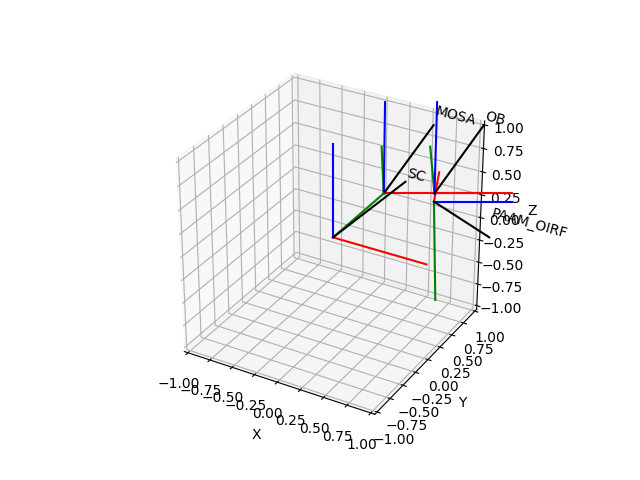

In [222]:
ax = sg.plot_frames_in("SC", s=1)
pyplot.show()

In [223]:

sg.write_png("test.png")

![image](test.png)

## Raytrace inside OB Frame
### define trace function

In [224]:
def trace_paam_effect(paam_static_rot=0, getrace=False):

    ''' this function implements the trace from the pre-paam beam up to the 
    exit from the OBA. All reflection are handled in the OB frame of reference
    The function accepts the following parameters
    
    paam_static_rot: rotation angle in radians of the paam around paam y
    gertrace: bool, request additional tracing output for visualization'''

    # define all surface normals of the reflecting elements in the OB frame

    paam_normal_OB= paam_static_rotation_OB(paam_static_rot) @ nvector([0,   -1.0,   1.0 ])
    beam_pre_paam_OB        = nvector([0,   1.0,    0   ])
    pbs1_normal_OB          = nvector([0,   -1.0,   -1.0])
    telif_normal_OB         = nvector([1.0, 1.0,    0   ])

    # Generate Reflection Matrices from normals

    paam_reflection_OB      = t3d.reflections.rfnorm2mat(paam_normal_OB)
    pbs1_reflection_OB      = t3d.reflections.rfnorm2mat(pbs1_normal_OB)
    telif_reflection_OB     = t3d.reflections.rfnorm2mat(telif_normal_OB)

    # matrix multiply initial beam direction according to optical sequence

    tx_beam_exit_OB = telif_reflection_OB @ pbs1_reflection_OB @ paam_reflection_OB @ beam_pre_paam_OB

    if getrace:
        pass
    else:
        return tx_beam_exit_OB #return the final beam direction

### execute analysis

In [225]:
tx_original_exit_OB = trace_paam_effect() # trace without applied paam offset
tx_mod_exit_OB = trace_paam_effect(-0.000221/2**0.5)  ## -156.27 matching the current requirement
rotation = np.cross(tx_original_exit_OB, tx_mod_exit_OB) # compute point ahead rotation in OB frame between the two beams

## Postprocessing
### in OB frame

In [226]:
print(f"original beam : {tx_original_exit_OB}")
print(f"offset beam   : {tx_mod_exit_OB}")
print(f"rotation      : {rotation}")
print("Check for requirement in OB Frame:")
print({False: "!!! The requirement is not met !!!", True: "The static offset pointing is compliant"}[np.isclose(rotation[2],-0.000221)])


original beam : [1. 0. 0.]
offset beam   : [ 9.99999976e-01 -2.20999996e-04 -2.44204998e-08]
rotation      : [ 0.00000000e+00  2.44204998e-08 -2.20999996e-04]
Check for requirement in OB Frame:
The static offset pointing is compliant


### in SC frame

In [227]:

print("Check for requirement in SC Frame:")
sc_rotation = sg.get_transform("OB","SC") @ np.append(rotation,[0])
print({False: "!!! The requirement is not met !!!", True: "The static offset pointing is compliant"}[np.isclose(sc_rotation[2],-0.000221)])


Check for requirement in SC Frame:
The static offset pointing is compliant


The requirement of -221µrad rotation around Z in OB frame is met, nota bene: the secondary effect in 4 orders of magnitude smaller, a 0.2µrad rotation around y which is small enough to be neglected in the alignment budget.
For this to verify also beyond OB frame, it needs to be enforced that OB Z is coalligned with MOSA and SC Z.

### some sanity checks

In [228]:
# plot the trace in 3d with the coordinate frames visualized

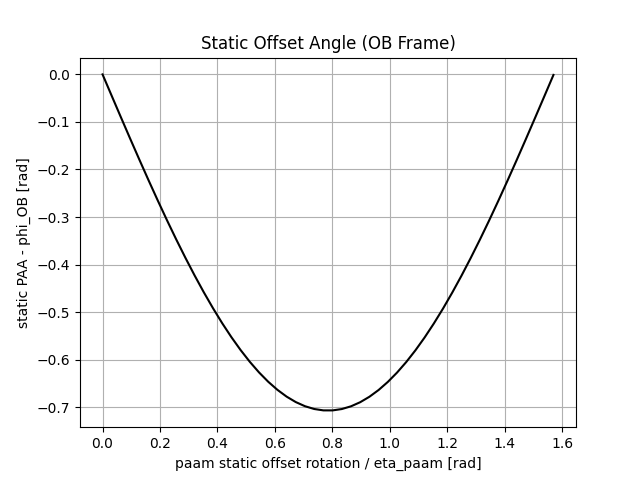

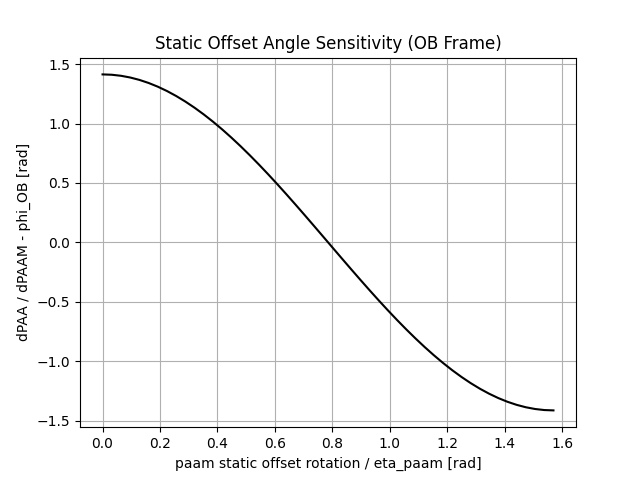

In [229]:
rotation_OB_z = [np.cross(tx_original_exit_OB, trace_paam_effect(rot))[-1] for rot in np.linspace(0,-3.14/2)]

pyplot.figure()
pyplot.plot(np.linspace(0,3.14/2),rotation_OB_z, 'black')
pyplot.title("Static Offset Angle (OB Frame)")
pyplot.xlabel("paam static offset rotation / eta_paam [rad]")
pyplot.ylabel("static PAA - phi_OB [rad]")
pyplot.grid("Both")
pyplot.figure()
pyplot.plot(np.linspace(0,3.14/2),np.gradient((rotation_OB_z),np.linspace(0,-3.14/2)), 'black')
pyplot.title("Static Offset Angle Sensitivity (OB Frame)")
pyplot.xlabel("paam static offset rotation / eta_paam [rad]")
pyplot.ylabel("dPAA / dPAAM - phi_OB [rad]")
pyplot.grid("Both")